In [1]:
from bs4 import BeautifulSoup
from datetime import datetime
import requests

import calendar
from tqdm.notebook import tqdm
import pickle
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

import json
from urllib.request import urlopen
import math

import string
import re
from nltk.corpus import stopwords
import pandas as pd

from nltk.stem.snowball import SnowballStemmer

### Data Collection

In [5]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT x.y; Win64; x64; rv:10.0) Gecko/20100101 Firefox/10.0'}

archive_url_2020 = 'https://archive.org/details/TV-FOXNEWSW?sort=-publicdate&and[]=year%3A"2020"&page='
archive_url_2021 = 'https://archive.org/details/TV-FOXNEWSW?sort=-publicdate&and[]=year%3A"2021"&page='
archive_url_2022 = 'https://archive.org/details/TV-FOXNEWSW?sort=-publicdate&and[]=year%3A"2022"&page='
archive_url_2023 = 'https://archive.org/details/TV-FOXNEWSW?sort=-publicdate&and[]=year%3A"2023"&page='


total_pages_2020 = 111
total_pages_2021 = 107
total_pages_2022 = 111
total_pages_2023 = 54

In [6]:
def get_set_articles_urls(url_base_format,num_pages):
    set_articles_urls = []
    
    try:
        for page in tqdm(range(num_pages)):
            cur_url = url_base_format + str(page+1)

            cur_req = requests.get(cur_url,headers=headers)
            cur_soup = BeautifulSoup(cur_req.content,'lxml')

            article_entry_points = cur_soup.find_all('div',{'class':'item-ttl'})

            article_anchors = ['https://archive.org' + article_entry_points[i].find('a').get('href') for i in range(len(article_entry_points))]
            set_articles_urls.extend(article_anchors)
    except:
        print('Idk, something broke')
        
    return set_articles_urls

In [103]:
article_sets_urls_2020 = get_set_articles_urls(archive_url_2020,total_pages_2020)

100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:47<00:00,  1.04it/s]


In [110]:
article_sets_urls_2021 = get_set_articles_urls(archive_url_2021,total_pages_2021)

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [01:51<00:00,  1.04s/it]


In [115]:
article_sets_urls_2022 = get_set_articles_urls(archive_url_2022,total_pages_2022)

100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [02:03<00:00,  1.11s/it]


In [5]:
article_sets_urls_2023 = get_set_articles_urls(archive_url_2023,total_pages_2023)

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:37<00:00,  1.80s/it]


In [7]:
def get_article_dates(article_urls):
    dates_unsplit = [''.join(article_urls[i].split('/')).split('_')[1] for i in range(len(article_urls))]
    split_dates = [(date[:4],date[4:6],date[-2:]) for date in dates_unsplit]
    
    return dict(zip(article_urls,split_dates))


In [8]:
def get_article_contents(article_set_urls,num_rand_articles):
    
    article_date_dict = get_article_dates(article_set_urls)
    article_date_pairings = {}
    
    random_indices = np.random.randint(low=0,high=len(article_set_urls),size=num_rand_articles)
    rand_article_sets = np.array(article_set_urls)[random_indices]
        
    for article_set_url in tqdm(rand_article_sets):
    
        associated_date = article_date_dict[article_set_url]
        year, month,day = int(associated_date[0]),int(associated_date[1]), int(associated_date[2])
        
        #Looking at only data past March 11,2020 ()
        if (month < 3 and day < 11) and year == 2020:
            continue
        
        cur_article_req = requests.get(article_set_url,headers=headers)
        cur_article_soup = BeautifulSoup(cur_article_req.content,'lxml')
        
        article_snippets = cur_article_soup.find_all('div',{'class':'snipin nosel'})
        text_snippets = [snippet.text.replace('\n','').replace('\t','') for snippet in article_snippets]
        
        for snippet in text_snippets:
            article_date_pairings[snippet] = associated_date
    
    return article_date_pairings

In [8]:
num_rand_articles = 2000

In [10]:
article_date_pairings_2023 = get_article_contents(article_sets_urls_2023,num_rand_articles) 

In [14]:
with open('Serialized Datasets/2023_articles.pkl','wb') as pickle_file:
    pickle.dump(article_date_pairings_2023,pickle_file)

### Creating Tables from Scraped Data

In [2]:
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    sentiment = sentiment_scores['compound']
    
    return sentiment

In [3]:
article_date_pairings_2020 = pickle.load(open('Serialized Datasets/2020_articles.pkl','rb'))
article_date_pairings_2021 = pickle.load(open('Serialized Datasets/2021_articles.pkl','rb'))
article_date_pairings_2022 = pickle.load(open('Serialized Datasets/2022_articles.pkl','rb'))
article_date_pairings_2023 = pickle.load(open('Serialized Datasets/2023_articles.pkl','rb'))

### Combing now the tables from all of the years

In [4]:
combined_dict = {
    '2020':article_date_pairings_2020,
    '2021':article_date_pairings_2021,
    '2022':article_date_pairings_2022,
    '2023':article_date_pairings_2023
}

all_articles = []
all_dates = []

for year in combined_dict.keys():
    current_articles,current_dates = combined_dict[year].keys(), combined_dict[year].values()
                                                                                    
    all_articles.extend(current_articles),all_dates.extend(current_dates)

In [5]:
len(all_articles),len(all_dates)

(398661, 398661)

In [6]:
years = [all_dates[i][0]  for i in range(len(all_dates))]
months = [all_dates[i][1]  for i in range(len(all_dates))]
days = [all_dates[i][2]  for i in range(len(all_dates))]

reformatted_dates = [f'{years[i]}-{months[i]}-{days[i]}' for i in range(len(years))]

In [7]:
full_table = pd.DataFrame({
    'Article Text':all_articles,
    'Year':years,
    'Month':months,
    'Day':days,
    'Full Date':reformatted_dates
})

full_table

,Article Text,Year,Month,Day,Full Date
0,at -- actually 49 days and 2 hours...,2020,09,15,2020-09-15
1,popular vote. >> his selection is ...,2020,09,15,2020-09-15
2,>> you know the old saying no news...,2020,09,15,2020-09-15
3,all age groups. the hospitalizatio...,2020,09,15,2020-09-15
4,and dr. fauci didn't elaborate on ...,2020,09,15,2020-09-15
...,...,...,...,...,...
398656,>> that's right. whoever has the c...,2023,05,26,2023-05-26
398657,it's really bad for you but i feel...,2023,05,26,2023-05-26
398658,>> i think we cracked the case. >>...,2023,05,26,2023-05-26
398659,scratcher eyeball. >> i'm going to...,2023,05,26,2023-05-26


In [8]:
#Nhan's pre-processing function

pattern = re.compile(r'[^A-Za-z0-9 ]+')
stopword_set = set([word.lower() for word in stopwords.words('english')])
stemmer = SnowballStemmer('english')

def preprocess_article(article: str) -> str:
    article = article.lower()
    article = article.translate(str.maketrans('', '', string.punctuation))
    article = pattern.sub('', article)
    
    content = nltk.word_tokenize(article)
    content = [stemmer.stem(word) for word in content if word.lower() not in stopword_set]

    final = ' '.join(content)
    return final

In [9]:
tqdm.pandas(desc='Applying text-pre processing')

processed_text = full_table['Article Text'].progress_apply(preprocess_article)

Applying text-pre processing:   0%|          | 0/398661 [00:00<?, ?it/s]

In [11]:
full_table['Article Text'] = processed_text

In [14]:
tqdm.pandas(desc='Calculating Polarity Scores')
polarity_scores = full_table['Article Text'].progress_apply(analyze_sentiment)

Calculating Polarity Scores:   0%|          | 0/398661 [00:00<?, ?it/s]

In [15]:
full_table['Polairty Score'] = polarity_scores

In [16]:
full_table

,Article Text,Year,Month,Day,Full Date,Polairty Score
0,actual 49 day 2 hour cosco target walmart disc...,2020,09,15,2020-09-15,0.9393
1,popular vote select back nnever easi republica...,2020,09,15,2020-09-15,0.5687
2,know old say news good news well covid concern...,2020,09,15,2020-09-15,0.8860
3,age group hospit death arizona texa florida al...,2020,09,15,2020-09-15,-0.9118
4,dr fauci didnt elabor drop bombshel your talk ...,2020,09,15,2020-09-15,0.6921
...,...,...,...,...,...,...
398656,that right whoever open be go cook someth myst...,2023,05,26,2023-05-26,0.6369
398657,realli bad feel like need storyit could one ho...,2023,05,26,2023-05-26,-0.7774
398658,think crack case car wheel scissor peopl butt ...,2023,05,26,2023-05-26,0.8509
398659,scratcher eyebal im go take kid let go applauseu,2023,05,26,2023-05-26,0.0000


In [17]:
full_table.to_csv('full_table.csv')

### Getting Covid Statistics to make other intermediate tables from an External API

In [58]:
api_key = '3683057711b142c8a7508f588006e6be'
request_link = 'https://api.covidactnow.org/v2/country/US.timeseries.json?apiKey=' + api_key

response = urlopen(request_link).read()
response_json = json.loads(response.decode('utf-8','strict'))

> Possible data we can extract. Let's see which ones to use.

In [59]:
response_json

{'fips': '0',
 'country': 'US',
 'state': None,
 'county': None,
 'hsa': None,
 'hsaName': None,
 'level': 'country',
 'lat': None,
 'locationId': 'iso1:us',
 'long': None,
 'population': 331486822,
 'hsaPopulation': None,
 'metrics': {'testPositivityRatio': None,
  'testPositivityRatioDetails': {'source': 'other'},
  'caseDensity': None,
  'weeklyNewCasesPer100k': None,
  'contactTracerCapacityRatio': None,
  'infectionRate': None,
  'infectionRateCI90': None,
  'icuCapacityRatio': 0.69,
  'bedsWithCovidPatientsRatio': 0.015,
  'weeklyCovidAdmissionsPer100k': 2.2,
  'vaccinationsInitiatedRatio': 0.793,
  'vaccinationsCompletedRatio': 0.682,
  'vaccinationsAdditionalDoseRatio': 0.356,
  'vaccinationsFall2022BivalentBoosterRatio': 0.162},
 'riskLevels': {'overall': 4,
  'testPositivityRatio': 4,
  'caseDensity': 4,
  'contactTracerCapacityRatio': 4,
  'infectionRate': 4,
  'icuCapacityRatio': 0},
 'cdcTransmissionLevel': 4,
 'communityLevels': {'cdcCommunityLevel': None, 'canCommunityLe

> The outputted JSON is a little bit confusing at first glance, but upon closer inspection, the first couple of keys given COVID data just for the current date, and one of these keys, 'metricsTimeseries' is a list of JSON entries itself that give summary statistics for the past 1182 days, (since March 9, 2020). This is very convenient for our purposes, as COVID was declared an epidemic by the WHO on March 11, 2020. Thus, we use this particular API over others because of the extent of information it provides over 3 years, instead of the 1-2 years at most that other APIs provide. 

> Let's dive into the structure of this dictionary a bit more. 

In [60]:
time_series_json = response_json['metricsTimeseries']
time_series_json[0]

{'testPositivityRatio': None,
 'caseDensity': 0.0,
 'weeklyNewCasesPer100k': 0.0,
 'contactTracerCapacityRatio': None,
 'infectionRate': None,
 'infectionRateCI90': None,
 'icuCapacityRatio': None,
 'bedsWithCovidPatientsRatio': None,
 'weeklyCovidAdmissionsPer100k': None,
 'date': '2020-03-09'}

> For many of the earlier entries, there is an issue of None entries. As we convert the data into a usable format later on, we will replace these values with a 0. For now, we just wish to parse the data, and convert it into a more convenient form so that we can readily construct a table with it. 

In [61]:
keys = time_series_json[0].keys()
data = [[] for _ in keys]

time_series_dict = dict(zip(keys,data))

for entry in time_series_json:
    for key in entry:
        try:
            time_series_dict[key].append(entry[key])
            
        #Some ragged entries - keys only for some special areas of time like Fall 2022 Booster Received Rate
        except KeyError:
            continue

In [62]:
covid_data_table = pd.DataFrame(time_series_dict)
covid_data_table

,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,contactTracerCapacityRatio,infectionRate,infectionRateCI90,icuCapacityRatio,bedsWithCovidPatientsRatio,weeklyCovidAdmissionsPer100k,date
0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-09
1,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-10
2,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-11
3,NaN,0.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-12
4,NaN,0.1,0.4,NaN,1.83,0.83,NaN,NaN,NaN,2020-03-13
...,...,...,...,...,...,...,...,...,...,...
1180,NaN,NaN,NaN,NaN,NaN,NaN,0.72,0.015,2.3,2023-06-02
1181,NaN,NaN,NaN,NaN,NaN,NaN,0.71,0.015,2.3,2023-06-03
1182,NaN,NaN,NaN,NaN,NaN,NaN,0.70,0.015,2.3,2023-06-04
1183,NaN,NaN,NaN,NaN,NaN,NaN,0.69,0.015,2.3,2023-06-05


> For each column, let us observe the proportion of NaN or None values so that we can see if it is usable and we just need to convert a couple of values to zeroes, or if there is simply too much missing data.

> Generally, more complicated techniques can be pursued to fill in missing data, such as the EM algorithm, however, we do not pursue this here. 

In [63]:
columns = covid_data_table.columns.values
missing_values_proportion_dict = {}

for column in columns:
    cur_column = covid_data_table[column].values
    try:
        proportion_missing = np.sum(np.isnan(cur_column))/len(cur_column)
    
    #A mix of NaN and none values stored, so if using isnan this breaks, have to check if it is None
    except TypeError:
        proportion_missing = np.sum(cur_column == None) / len(cur_column)
    
    missing_values_proportion_dict[column] = proportion_missing
    
missing_values_proportion_dict

{'testPositivityRatio': 0.031223628691983123,
 'caseDensity': 0.05907172995780591,
 'weeklyNewCasesPer100k': 0.05907172995780591,
 'contactTracerCapacityRatio': 0.5088607594936709,
 'infectionRate': 0.026160337552742614,
 'infectionRateCI90': 0.026160337552742614,
 'icuCapacityRatio': 0.18565400843881857,
 'bedsWithCovidPatientsRatio': 0.18565400843881857,
 'weeklyCovidAdmissionsPer100k': 0.19071729957805908,
 'date': 0.0}

> Some of these columns have too much missing data for them to be usable, so we will drop them from the table, specifically the 'contractTracerCapacityRatio','bedsWithCovidPatientsRatio','icuCapacityRatio',and the 'weeklyCovidAdmissionsPer100k' columns

In [64]:
covid_data_table = covid_data_table.drop(columns = ['contactTracerCapacityRatio',
                                                    'icuCapacityRatio',
                                                    'bedsWithCovidPatientsRatio',
                                                    'weeklyCovidAdmissionsPer100k'])

In [65]:
covid_data_table = covid_data_table.dropna(0)
covid_data_table

c:\users\20gun\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """Entry point for launching an IPython kernel.


,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,infectionRate,infectionRateCI90,date
5,0.128,0.1,0.6,1.83,0.12,2020-03-14
6,0.124,0.1,0.7,1.83,0.10,2020-03-15
7,0.131,0.1,1.0,1.82,0.10,2020-03-16
8,0.129,0.2,1.4,1.81,0.10,2020-03-17
10,0.127,0.4,2.8,1.79,0.10,2020-03-19
...,...,...,...,...,...,...
1152,0.050,3.6,25.0,1.09,0.10,2023-05-05
1153,0.050,3.5,24.5,1.11,0.10,2023-05-06
1154,0.050,3.4,24.1,1.13,0.10,2023-05-07
1155,0.049,3.4,23.7,1.15,0.10,2023-05-08


In [66]:
full_table = pd.read_csv('full_table.csv')
full_table = full_table.rename(columns = {'Polairty Score':'Polarity Score'})
full_table_grouped = full_table.groupby('Full Date').mean()['Polarity Score']
full_table_grouped

Full Date
2020-01-11    0.204844
2020-01-12    0.134130
2020-01-13    0.158166
2020-01-14    0.221843
2020-01-15    0.339110
                ...   
2023-06-01    0.359643
2023-06-02    0.221385
2023-06-03    0.386211
2023-06-04    0.359589
2023-06-05    0.236877
Name: Polarity Score, Length: 1225, dtype: float64

In [67]:
len(covid_data_table.index)

1106

In [68]:
covid_table_dates = covid_data_table['date'].values
fox_table_dates = full_table_grouped.index

In [69]:
covid_data_table = covid_data_table.reset_index()
covid_data_table

,index,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,infectionRate,infectionRateCI90,date
0,5,0.128,0.1,0.6,1.83,0.12,2020-03-14
1,6,0.124,0.1,0.7,1.83,0.10,2020-03-15
2,7,0.131,0.1,1.0,1.82,0.10,2020-03-16
3,8,0.129,0.2,1.4,1.81,0.10,2020-03-17
4,10,0.127,0.4,2.8,1.79,0.10,2020-03-19
...,...,...,...,...,...,...,...
1101,1152,0.050,3.6,25.0,1.09,0.10,2023-05-05
1102,1153,0.050,3.5,24.5,1.11,0.10,2023-05-06
1103,1154,0.050,3.4,24.1,1.13,0.10,2023-05-07
1104,1155,0.049,3.4,23.7,1.15,0.10,2023-05-08


In [70]:
available_dates = covid_data_table['date'].values
rows_to_drop = []

available_polarity_scores = []

dates_to_ignore = set(covid_table_dates).difference(set(fox_table_dates))
for row in covid_data_table.index:
    if covid_data_table.iloc[row].date in dates_to_ignore:
        rows_to_drop.append(row)

for i in range(len(full_table_grouped.index)):
    cur_date = full_table_grouped.index[i]
    if cur_date in available_dates:
        available_polarity_scores.append(full_table_grouped[i])
        
for row in rows_to_drop:
    covid_data_table = covid_data_table.drop(row)

len(available_polarity_scores),len(covid_data_table['date'].values)

(1099, 1099)

In [71]:
covid_data_table['Polarity Scores'] = available_polarity_scores

In [77]:
covid_data_table = covid_data_table.drop(columns=['infectionRateCI90'])

In [78]:
covid_data_table = covid_data_table.drop(columns=['weeklyNewCasesPer100k'])

In [79]:
covid_data_table

,index,testPositivityRatio,caseDensity,infectionRate,date,Polarity Scores
0,5,0.128,0.1,1.83,2020-03-14,0.427703
1,6,0.124,0.1,1.83,2020-03-15,0.450716
2,7,0.131,0.1,1.82,2020-03-16,0.321825
3,8,0.129,0.2,1.81,2020-03-17,0.449744
4,10,0.127,0.4,1.79,2020-03-19,0.410640
...,...,...,...,...,...,...
1101,1152,0.050,3.6,1.09,2023-05-05,0.270646
1102,1153,0.050,3.5,1.11,2023-05-06,0.397678
1103,1154,0.050,3.4,1.13,2023-05-07,0.148437
1104,1155,0.049,3.4,1.15,2023-05-08,0.188102


### Visualizations:

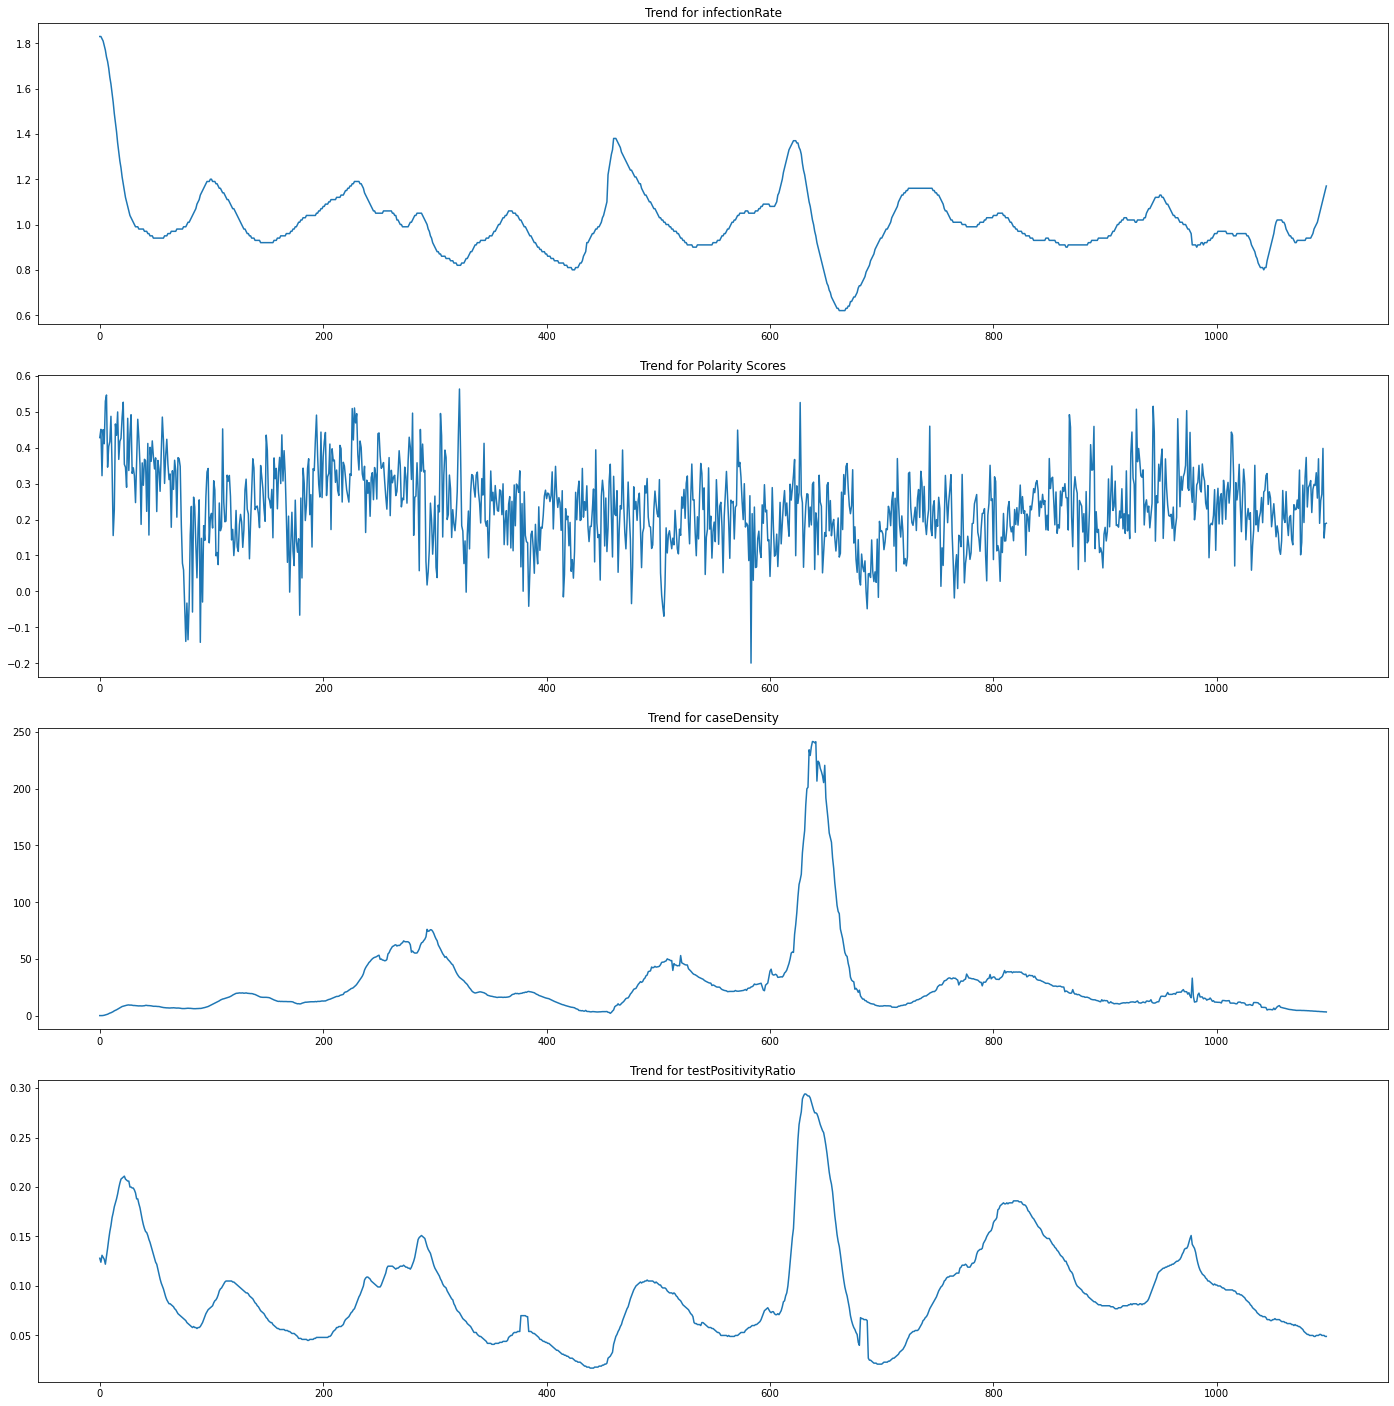

In [80]:
columns = list(set(covid_data_table.columns).difference({'date','index'}))
fig,ax = plt.subplots(len(columns),figsize=(20,20))
fig.tight_layout(pad=3.0)


for i in range(len(columns)):
    cur_column = columns[i]
    ax[i].plot(covid_data_table[cur_column].values)
    ax[i].set_title(f'Trend for {cur_column}')
    
plt.show()

In [81]:
covid_data_table.corr()

,index,testPositivityRatio,caseDensity,infectionRate,Polarity Scores
index,1.000000,0.061893,0.012226,-0.230798,-0.158294
testPositivityRatio,0.061893,1.000000,0.665269,0.134817,0.145463
caseDensity,0.012226,0.665269,1.000000,-0.117906,-0.051615
infectionRate,-0.230798,0.134817,-0.117906,1.000000,0.192342
Polarity Scores,-0.158294,0.145463,-0.051615,0.192342,1.000000


> Correlation between caseDensity and weeklyNewCasesPer100k... makes sense. We drop it. Drop weeklyNewCasesPer100k column since other columns are a ratio/proportion and so is caseDensity. 

In [82]:
try:
    covid_data_table = covid_data_table.drop(columns = ['weeklyNewCasesPer100k'])
except KeyError:
    print('Already Dropped')

Already Dropped


In [86]:
covid_data_table = covid_data_table.drop(columns=['index'])

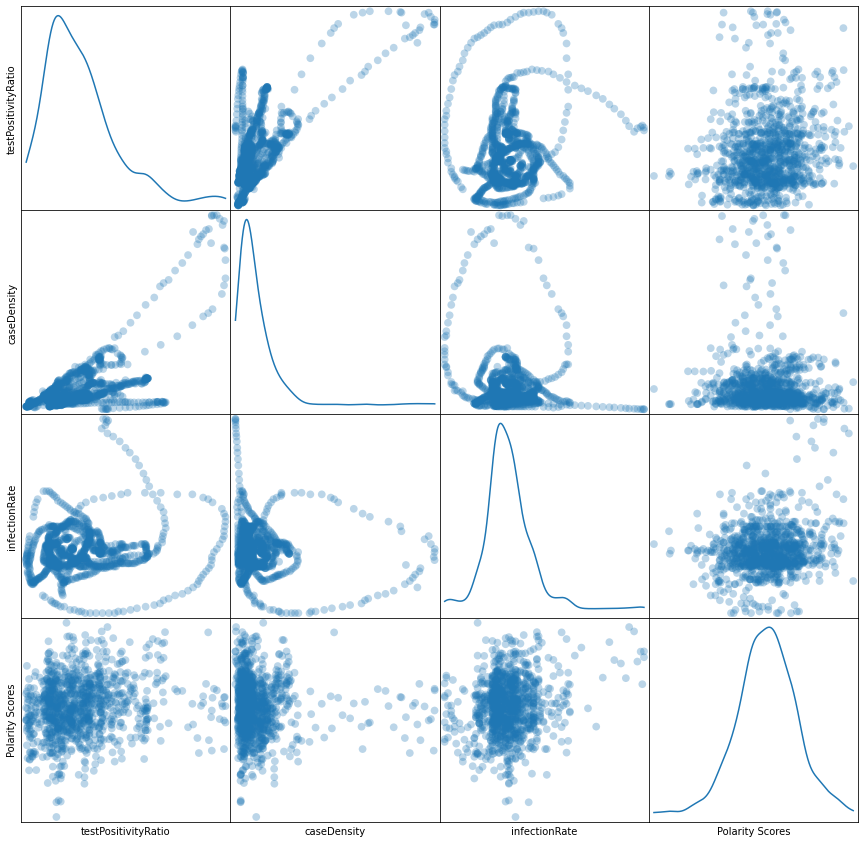

In [87]:
pair_plots = pd.plotting.scatter_matrix(covid_data_table,figsize=(15,15),marker='o', 
                                        hist_kwds={'bins': 20}, s=60, alpha=.3,diagonal='kde')

for subaxis in pair_plots:
    for ax in subaxis:
        ax.xaxis.set_ticks([]);
        ax.yaxis.set_ticks([]);
        
plt.xticks(fontsize=5);
plt.yticks(fontsize=5);

In [96]:
years = []
months = []

for date in covid_data_table.date.values:
    split_date = date.split('-')
    year,month = split_date[0],split_date[1]
    
    years.append(year),months.append(month)

In [97]:
covid_data_table['Year'] = years
covid_data_table['Month'] = months

In [103]:
summarized_by_year = covid_data_table.groupby('Year').mean()
summarized_by_year

,testPositivityRatio,caseDensity,infectionRate,Polarity Scores
Year,,,,
2020,0.096469,19.690909,1.078042,0.287622
2021,0.067716,28.326100,1.003167,0.207275
2022,0.118020,38.453561,0.975328,0.213387
2023,0.079074,9.149587,0.946777,0.241727
